# Finite Difference
## November 3rd, 2022
### Overview: Using finite difference methods to approximate solutions to ODEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.sparse import diags

In [2]:
%matplotlib inline

# Problem 1

Let $u(x) = sin((x + \pi)^2 - 1)$. Use (1.3) - (1.6) to approximate $\frac{1}{2}
u'' − u'$ at the grid points where $a = 0$, $b = 1$, and $n = 10$. Graph the result.

In [9]:
#make the tridiagonal matrix for first deriv as shown in the file
n = 10
k = [np.ones(n-1-1),np.zeros(n-1),np.ones(n-1-1)]
offset = [-1,0,1]
A = diags(k,offset).toarray()

#interval
x = np.linspace(0,1,n+1)

#u function, step size
u = lambda x: np.sin( (x+np.pi)**2  - 1  )
ux = u(x)
h = x[1]-x[0]

#get vector that's being added
second_vec = np.zeros(n-1)
second_vec[0] = -ux[0]/(2*h)
second_vec[-1] = ux[-1]/(2*h)

#first derivative approx
first_deriv = 1/(2*h) * A@ux[1:-1] + second_vec

#make tridiag for second matrix
k = [np.ones(n-1-1),-2*np.ones(n-1),np.ones(n-1-1)]
offset = [-1,0,1]
B = diags(k,offset).toarray()

#get second vector that's being added
second_vec = np.zeros(n-1)
second_vec[0] = -ux[0]/(h**2)
second_vec[-1] = ux[-1]/(h**2)

#second derivative approx
second_deriv = 1/(h**2) * B@ux[1:-1] + second_vec

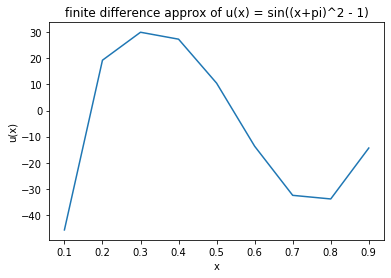

In [10]:
plt.title("finite difference approx of u(x) = sin((x+pi)^2 - 1)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.plot(x[1:-1],0.5*second_deriv - first_deriv)
plt.show()

# Problem 2

Equation (1.7) is the singularly perturbed boundary value problem
\begin{align*}
	&{ } \varepsilon u''(x)-u(x)'= f(x), \quad x \in (0,1), \\
	&{ } u(0) = \alpha, \quad u(1) = \beta.
\end{align*}

Use equation (1.9) to solve the singularly perturbed BVP (1.7) on $[0,1]$ with $\varepsilon = 1/10, f(x) = -1, \alpha=1,$ and $\beta=3$ on a grid with $n=30$ subintervals. Graph the solution. This BVP is called singularly perturbed because of the location of the parameter $\varepsilon$. For $\varepsilon=0$ the ODE has a drastically different character - it then becomes first order, and can no longer support two boundary conditions.

In [6]:
def prob2(n,eps=0.1,alph=1,beta=3,f=-1):
    """Solve the equation above with epsilon (float), bounds alpha and beta (float or int), and f (function or float/int)"""
    #interval, step size
    x = np.linspace(0,1,n+1)
    h = x[1] - x[0]
    
    #make tridiag matrix as in file
    k = [(eps+0.5*h)*np.ones(n-1-1),-2*eps*np.ones(n-1),(eps-0.5*h)*np.ones(n-1-1)]
    offset = [-1,0,1]
    A_inv = np.linalg.inv(diags(k,offset).toarray())
    
    # if int or float, just make vector of that number
    if type(f) == int or type(f) == float:
        f_vec = f*np.ones(n-1)
    #otherwise call it on the interval we're evaluating over
    else:
        f_vec = f(x[1:-1])
        
    #alter endpoints
    f_vec[0] = -1 - alph*(eps + 0.5*h)/(h**2)
    f_vec[-1] = -1 - beta*(eps - 0.5*h)/(h**2)
    
    #calculate U approx
    U = (h**2)*A_inv@f_vec
    return x,U

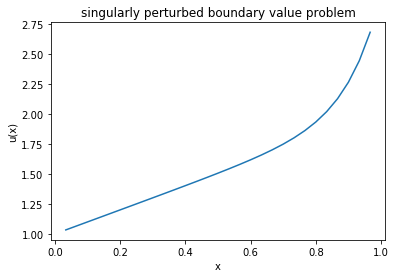

In [11]:
#get approx
x, U = prob2(30)
#plot
plt.plot(x[1:-1],U)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('singularly perturbed boundary value problem')
plt.show()

# Problem 3

Implement a function `singular_bvp` to compute the finite difference solution to (1.7).
Using $n = 5 \times 2^0,5 \times 2^1, \dots ,5 \times 2^9$ subintervals, compute 10 approximate solutions.
Use these to visualize the $\mathcal{O}(h^2)$ convergence of the finite difference method from Problem 2 by producing a loglog plot of error against subinterval count; this will be similar to Figure 2, except with $\varepsilon=0.1$. 

To produce the plot, treat the approximation with $n = 5 \times 2^9$ subintervals as the "true solution", and measure the error for the other approximations against it. ote that, since the ratios of numbers of subintervals between approximations are multiples of 2, we can compute the $L_{\infty}$ error for the $n=5 \times 2^j$ approximation by using the `step` argument in the array slicing syntax:

    # best approximation; the vector has length 5*2^9+1
    sol_best = singular_bvp(eps,alpha,beta,f,5*(2**9))

    # approximation with 5*(2^j) intervals; the vector has length 5*2^j+1
    sol_approx = singular_bvp(eps,alpha,beta,f,5*(2**j))

    # approximation error; slicing results in a vector of length 5*2^j+1,
    #    which allows it to be compared
    error = np.max(np.abs(sol_approx - sol_best[::2**(9-j)]))


In [13]:
def singular_bvp(eps,alpha,beta,f,n):
    """
    Solves the singularly perturbed BVP (1.7) on the interval [0,1] using finite differences.
    
    Parameters:
        eps (float): the singular perturbation parameter of the BVP.
        alpha (float): the boundary value of u at x=0.
        beta (float): the boundary value of u at x=1.
        f (callable): the right-hand function of the BVP.
        n (int): the number of subintervals to use in the finite differences method.
        
    Returns:
        ((n+1,) ndarray): the approximated solution to the BVP, including the boundary points.
    """
    #use prob 2 to get approx U
    x,U = prob2(n,eps,alpha,beta,f)
    
    #add on boundary points
    U = np.concatenate( ( np.array([alpha]), U, np.array([beta])   )   )
    return U

In [14]:
#define conditions, function, get approx for each condition
Ns = [5 * 2**i for i in range(10)]
hs = [1/n for n in Ns]
f  = lambda x: -1*np.ones(len(x))
Us = []
for n in Ns:
    Us.append(singular_bvp(0.1,1,3,f,n))

In [15]:
#calculate errors
errs = []
sol_best = Us[-1]
for j, sol_approx in enumerate(Us[:-1]):
    errs.append(np.max(np.abs(sol_approx - sol_best[::2**(9-j)])))

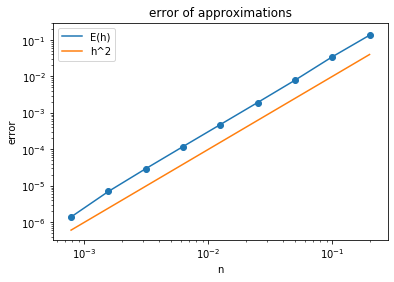

In [16]:
plt.xscale('log')
plt.yscale('log')
plt.plot(hs[:-1],errs,label='E(h)')
plt.scatter(hs[:-1],errs)
plt.plot(hs[:-1],[h**2 for h in hs[:-1]],label='h^2')
plt.xlabel('n')
plt.ylabel('error')
plt.title('error of approximations')
plt.legend()
plt.show()

# Problem 4

Extend your finite difference code to the case of a general second order linear BVP with boundary conditions:

\begin{align*}
	&{ } a_1(x)y''(x) +a_2(x)y'(x)+ a_3(x) y(x) = f(x), \quad x \in (a,b),\\
	&{ } y(a) = \alpha, \quad y(b) = \beta.
\end{align*}

Use your code to solve the boundary value problem

\begin{align*}
	\varepsilon y''(x) - 4(\pi - x^2)y(x) = \cos x, \\
	y(0) = 0, \quad y(\pi/2) = 1,
\end{align*}

for $\varepsilon = 0.1$ on a grid with $n=30$ subintervals. Plot your solution.

In [17]:
def bvp(a,b,alpha,beta,a1,a2,a3,f,n):
    """
    Computes the solution to the BVP:
        
        a1(x)y'' + a2(x)y' + a3(x)y = f
        y(a) = α, y(b) = β
        
    using finite differences.
    
    Parameters:
        a, b (float): the left and right boundary points.
        alpha (float): the boundary value of y at x=a.
        beta (float): the boundary value of y at x=b.
        f (callable): the right-hand function of the BVP.
        a1, a2, a3 (callable): the coefficient functions of the BVP.
        n (int): the number of subintervals to use in the finite differences method.
        
    Returns:
        ((n+1,) ndarray): the approximated solution to the BVP, including the boundary points.
    """
    #linspace and step size
    x = np.linspace(a,b,n+1)
    h = x[1]-x[0]
    
    #get each function over the space
    a1x = a1(x)
    a2x = a2(x)
    a3x = a3(x)
    fx  = f(x)[1:n]
    
    #create diagonals for matrix
    above_diag = a1x + 0.5*h*a2x
    main_diag  = -2*a1x + (h**2)*a3x
    below_diag = a1x - 0.5*h*a2x
    
    #truncate the diags to fit
    above_diag = above_diag[1:n-1]
    main_diag  = main_diag[1:n]
    below_diag = below_diag[2:n]
    
    #create the matrix
    k = [below_diag,main_diag,above_diag]
    offset = [-1,0,1]
    A_inv = h**2 * np.linalg.inv(diags(k,offset).toarray())
    
    #set endpoints
    fx[0]  = fx[0] - alpha*(a1x[1] - 0.5*h*a2x[1])/(h**2)
    fx[-1] = fx[-1] - beta*(a1x[n-1] + 0.5*h*a2x[n-1])/(h**2)
    
    #calculate U with its boundaries
    U = A_inv@fx
    U = np.concatenate(( np.array([alpha]), U, np.array([beta])   ))
    return U

In [18]:
#solve this guy with the given functions
a1 = lambda x: 0.1*np.ones(len(x))
a2 = lambda x: np.zeros(len(x))
a3 = lambda x: -4*(np.pi - x**2)
f  = lambda x: np.cos(x)
Y = bvp(a=0,b=np.pi/2,alpha=0,beta=1,a1=a1,a2=a2,a3=a3,f=f,n=30)
print(Y)

[ 0.         -0.03479634 -0.05419206 -0.06492716 -0.07077687 -0.07385328
 -0.0753367  -0.07588554 -0.07586546 -0.075477   -0.07482595 -0.07396132
 -0.07289421 -0.07160472 -0.07004001 -0.06810413 -0.06563844 -0.06238964
 -0.05796097 -0.05174028 -0.04279775 -0.02974508 -0.01054986  0.01769683
  0.05905066  0.11899426  0.20466931  0.32495965  0.49027037  0.71179226
  1.        ]


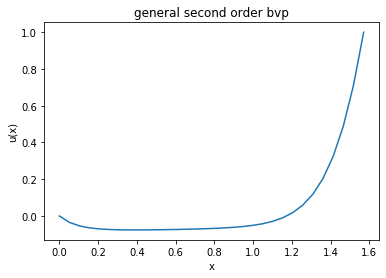

In [20]:
#plotting solutions
plt.plot(np.linspace(0,np.pi/2,len(Y)),Y)
plt.title('general second order bvp')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.show()

# Problem 5

Numerically solve the boundary value problem

\begin{align*}
	\varepsilon y''(x) + xy'(x) = -\varepsilon \pi^2 \cos(\pi x) - \pi x \sin(\pi x), \\
	y(-1) = -2, \quad y(1) = 0,
\end{align*}

for $\varepsilon = 0.1, 0.01,$ and $0.001$. Use a grid with $n=150$ subintervals. Plot your solutions.

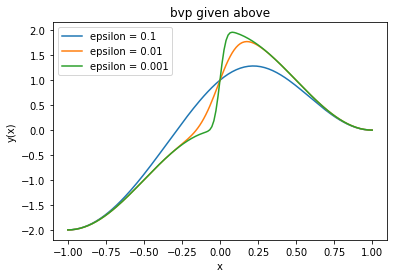

In [22]:
#epsilons
EPS = [0.1,0.01,0.001]

#for each epsilon, run approx
for eps in EPS:
    a1 = lambda x: eps*np.ones(len(x))
    a2 = lambda x: x
    a3 = lambda x: np.zeros(len(x))
    f  = lambda x: -eps*(np.pi**2)*np.cos(np.pi*x) - np.pi*x*np.sin(np.pi*x)
    Y = bvp(a=-1,b=1,alpha=-2,beta=0,a1=a1,a2=a2,a3=a3,f=f,n=150)
    #plot it
    plt.plot(np.linspace(-1,1,len(Y)),Y,label='epsilon = '+str(eps))
    
plt.title('bvp given above')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.show()

# Problem 6

Numerically solve the boundary value problem

\begin{align*}
	(\varepsilon +x^2)y''(x) + 4xy'(x) + 2y(x) = 0, \\
	y(-1) = 1/(1+\varepsilon), \quad y(1) = 1/(1+\varepsilon),
\end{align*}

for $\epsilon = 0.05$ and $0.02$. Use a grid with $n=150$ subintervals. Plot your solutions.

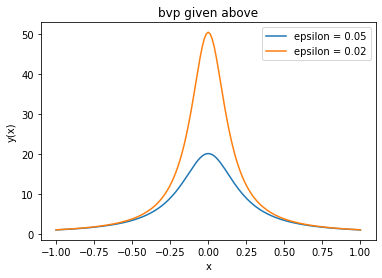

In [23]:
#epsilons
EPS = [0.05,0.02]

#for each epsilon, run approx
for eps in EPS:
    a1 = lambda x: eps + (x**2)
    a2 = lambda x: 4*x
    a3 = lambda x: 2*np.ones(len(x))
    f  = lambda x: np.zeros(len(x))
    Y = bvp(a=-1,b=1,alpha=1/(1+eps),beta=1/(1+eps),a1=a1,a2=a2,a3=a3,f=f,n=150)
    #plot
    plt.plot(np.linspace(-1,1,len(Y)),Y,label='epsilon = '+str(eps))

plt.title('bvp given above')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.show()